# VAE Training

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch, wandb, cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from vae import VAE, loss_fn
from camvid import *

/home/hexagon/miniconda3/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data
SHAPE = (66, 200)
batch_size = 2
latent = 25
IMAGE_PATH = "../CamVid/train/*.png"
VAL_PATH = "../CamVid/val/*.png"

train_dataset = CamVidDataset(SHAPE, IMAGE_PATH)
trainloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

val_dataset = CamVidDataset(SHAPE, VAL_PATH)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(SHAPE),
            transforms.ToTensor()
        ])

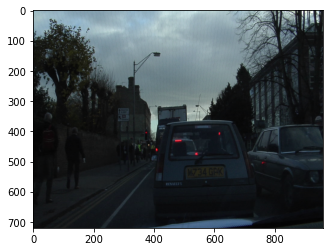

In [3]:
img = cv2.imread("../CamVid/train/0001TP_009240.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

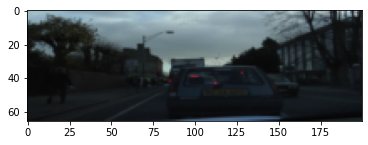

In [4]:
plt.imshow(np.moveaxis(train_dataset[0][0].detach().numpy(), 0, -1))
plt.show()

In [5]:
# config
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using dev {device}")
model = VAE(latent=latent).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(summary(model, (3, 66, 200)))

# init wandb
wandb.init(project="deepdriving-autoencoder")
config = wandb.config

# hyperparamters
config.batch_size = batch_size
config.epochs = 20
config.architecture = "vae"
config.activation = "relu"
config.input_size = SHAPE
config.latent_size = latent

using dev cuda:0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 31, 98]           1,824
              ReLU-2           [-1, 24, 31, 98]               0
            Conv2d-3           [-1, 36, 14, 47]          21,636
              ReLU-4           [-1, 36, 14, 47]               0
            Conv2d-5            [-1, 48, 5, 22]          43,248
              ReLU-6            [-1, 48, 5, 22]               0
            Conv2d-7            [-1, 64, 3, 20]          27,712
              ReLU-8            [-1, 64, 3, 20]               0
            Conv2d-9            [-1, 64, 1, 18]          36,928
             ReLU-10            [-1, 64, 1, 18]               0
          Flatten-11                 [-1, 1152]               0
           Linear-12                 [-1, 1000]       1,153,000
             ReLU-13                 [-1, 1000]               0
           Linear-14                  [

wandb: Currently logged in as: h3x4g0n. Use `wandb login --relogin` to force relogin


In [6]:
# training + logging loop
wandb.watch(model, log="all")

for epoch in range(config.epochs): 
    with tqdm(trainloader, unit="batch") as tepoch:

        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # encode -> kl loss -> decode -> mse loss
            x_hat, z, p, q = model(data)
            x_hat, z = x_hat.to(device), z.to(device)
            loss, kl_loss, mse_loss = loss_fn(x_hat, target, p, q)
            loss.backward()
            optimizer.step()

            # print statistics
            tepoch.set_postfix(loss=loss.item(), kl_loss=kl_loss.item(), mse_loss=mse_loss.item())

        # run inference
        img = cv2.imread("../CamVid/val/0001TP_009030.png")
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        inference = transform(img)
        run_inference = model(inference[None,:].to(device))[0].cpu().detach().numpy()
        result = np.moveaxis(run_inference[0], 0, -1)
        print(result)
        break

        # validation
        # TO DO: add validation

        # log
        wandb.log({
            "epoch": epoch+1,
            "loss": loss.item(),
            "kl_loss": kl_loss.item(),
            "mse_loss": mse_loss.item(),
            "val_inp": wandb.Image(img, caption="input"),
            "val_inf": wandb.Image(result, caption="inference")
        })

wandb.finish()
print('Finished Training')

Epoch 1: 100%|██████████| 185/185 [00:03<00:00, 53.57batch/s, kl_loss=8.81e-5, loss=0.0893, mse_loss=0.0892] 


[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.07639207 0.03143215 0.12851483]
  ...
  [0.07276796 0.02625914 0.13704067]
  [0.07751094 0.03039725 0.13071509]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


Finished Training
